# Estimation strategies

This notebook complements **Section IV: Performance references** of our paper [\[1\]][1]. Here, we implement our reference estimation strategies (see Section IV-B) and showcase them by simple examples.

## References

[\[1\]][1]: Pol del Aguila Pla, Lissy Pellaco, Satyam Dwivedi, Peter Händel and Joakim Jaldén, "Clock synchronization over networks — Identifiability of the sawtooth model", Preprint, submitted to _IEEE Transactions on  Control Systems Technology_, 2019.

## Index
<a id="index"></a>
1. Imports, configuration and flags
2. Periodogram and correlation peaks ([PCP](#PCP)), a fast heuristic solution
    1. [Example of use of the PCP](#example_1) on the standard sawtooth parameters
3. Local or Global [Grid-search](#GS) (LGS or GGS) on the prediction mean squared error (MSE)
    1. [Example of use of the LGS](#example_2) and the PCP on the physical clock synchronization and ranging parameters
    2. [Example of use of the GGS](#example_3) and the PCP on the physical clock synchronization and ranging parameters  

[1]:http://arxiv.org/abs/1906.08208

## Imports, configuration and flags

In [1]:
# Import both external libraries and our own basic functions
%run imports_and_library_of_basic_functions.ipynb
# Configure whether examples will be run (preserving options if previously stated)
if not 'run_examples' in dir( ):
    run_examples = True
# Configure whether interactive plots are preferred (preserving options if previosuly stated)
if not 'interactive' in dir( ):
    interactive = True
# Configure whether plots have to be exported to LaTeX (as done to obtain the ones in the paper)
export_to_latex = False
# Seed for reproducibility (if all the notebook is run in sequence)
np.random.seed( 482010 )

## Periodogram and correlation peaks (PCP), a fast heuristic solution
<a id="PCP"></a>
[Back to index](#index)

In [2]:
def PCP( y, sign_psi = -1, psi = None, plots = False, c = 3*10**8, psi_function = None,
         zero_padding_factor = 4, return_time = False ):
    
    # Start timing, if required
    if return_time:
        start = time.time( )
    else:
        execution_time = None
        
    # Library of functions to be used in the PCP method
    # Center a signal
    def remove_mean( signal ):
        ret_value = signal - np.mean( signal )
        return ret_value
    # Normalize a signal with respect to its maximum
    def max_normalize( signal ):
        return signal / np.max( signal )
    # Compute the circular correlation between a signal and two reference signals
    # using the FFT domain method
    def compute_circular_correlation( signal, reference_one, reference_two ):
        # Compute the signal's FFT
        fft_signal = np.conj( np.fft.rfft( signal ) )
        # Compute the circular convolution with the first reference
        correlation_one = np.fft.irfft( np.fft.rfft( reference_one ) * fft_signal )
        # Compute the circular convolution with the second reference
        correlation_two = np.fft.irfft( np.fft.rfft( reference_two ) * fft_signal )
        return (correlation_one, correlation_two)
    
    # If the amplitude is given, update sign_psi to match it
    if not psi == None:
        sign_psi = np.sign( psi )
    
    ## Phase 1: Estimate beta, up to the sign (zero-padded FFT power spectrum estimation)
    
    # Get signal length
    nrof_samples = y.size
    # Build zero-mean, zero-padded signal
    y_padded = np.concatenate( (remove_mean( y ), np.zeros( zero_padding_factor * nrof_samples )) )
    # Estimate power spectrum
    y_fft = np.fft.rfft( y_padded )
    y_power_spectrum = y_fft * np.conj( y_fft )
    # Get estimation of beta
    beta = np.argmax( y_power_spectrum ) / ( ( 1 + zero_padding_factor ) * nrof_samples ) 
    
    ## Phase 2: Estimate gamma and the sign of beta
    
    # Estimate the length of a period
    length_of_one_period = np.floor( 1 / beta ).astype( np.int )
    # Trim to maximum signal length, if needed
    if length_of_one_period > nrof_samples:
        length_of_one_period = nrof_samples
    
    # Generate reference waveforms at gamma = 0 for the positive and negative estimated betas
    # Get sample numbers as axis to generate reference signals
    n = np.arange( length_of_one_period )
    # Reference waveform with positive beta
    reference_waveform_plus  = max_normalize( remove_mean( sign_psi * mod_one( beta * n  ) ) )
    # Reference waveform with negative beta
    reference_waveform_minus = max_normalize( remove_mean( sign_psi * mod_one( -beta * n  ) ) )
    # The input signal is centered and normalized
    y_nomean_normalized = max_normalize( remove_mean( y[:length_of_one_period] ) )

    # Compute 1-(estimated)period circular correlation with the two reference signals
    correlation_plus, correlation_minus = compute_circular_correlation( y_nomean_normalized, 
                                          reference_waveform_plus, reference_waveform_minus )

    # Extract best correlation score and corresponding gamma
    # Positive beta (negative slope in the signal)
    plus =  np.max( correlation_plus )
    plus_arg = np.argmax( correlation_plus )
    # Negative beta (positive slope in the signal)
    minus = np.max( correlation_minus )
    minus_arg = np.argmax( correlation_minus )
            
    # Decide the sign of beta based on the correlation scores       
    if plus >= minus:
        # Keep positive beta and use correlation_plus to estimate gamma
        gamma = beta * plus_arg
    else:
        # Keep negative beta and use correlation_minus to estimate gamma
        beta = -beta
        gamma = beta * minus_arg
    
    # Control that gamma is in the correct range
    gamma = ( gamma )%(1)
    # Get anything at machine epsilon from 1 to 0, like in mod_one
    if gamma == 1:
        gamma = 0
    
    ## Phase 3: Estimate psi, if it is not given
    if psi == None:
        psi = psi_function( beta )
    
    ## Phase 4: Estimate alpha
    # Build a reference signal with current estimation for hard parameters and use MMSE estimator for alpha
    # Build time axis
    n = np.arange( nrof_samples )
    # Get reference signal
    reference_waveform = psi * mod_one( beta * n + gamma )
    # Minimum MSE estimation when psi, beta and gamma are fixed/known
    alpha = np.mean( y ) - np.mean( reference_waveform )  
    
    # Capture processing time, if required
    if return_time:
        execution_time = time.time( ) - start
        
    ## Plots section
    if plots:
        # Frequency estimation plots 
        plt.figure( figsize = [13, 15] )
        # Set subplot
        plt.subplot( 311 )
        # Plot FFT-based estimation of the power spectrum
        plt.plot( np.arange( y_power_spectrum.size ) / ( nrof_samples * ( 1+zero_padding_factor ) ), 
                  np.real( y_power_spectrum ), 'bx-', label = "Power spectrum" );
        # Plot the location of the maximum with a line and a mark
        plt.plot( np.abs( beta ), np.max( np.real( y_power_spectrum ) ), 'ro', label = "Max. power" )
        plt.plot( [np.abs( beta ), np.abs( beta )], 
                  [np.min( np.real( y_power_spectrum ) ), np.max( np.real( y_power_spectrum ) )], 'r-',
                  label = "Max. location" )
        # Set the title and labels
        plt.title( r'Power spectrum estimation $|Y[k]|^2$ - Maximum at $\nu$ = %f Fig. 1'%( np.abs(beta) ) );
        plt.xlabel( r'$\nu$ [1/sample]' );
        plt.legend( )
        # Print message with the same information to the user
        print( "The maximum of the power spectrum estimation is at nu = %f (see Fig. 1)."%( np.abs( beta ) ) +
               "This value is the PCP estimate of beta up to the sign." )
        
        # Reference signals plots
        # Plot the positive-beta reference waveform together with the data
        plt.subplot(323)
        # Plot the reference waveform (positive beta)
        plt.plot( reference_waveform_plus, 'b+-', label = "Reference +" ); 
        # Plot the data
        plt.plot( y_nomean_normalized, 'g+', label = "Data" ); 
        # Recover the estimated delay (in the right range)
        estimated_delay = (( beta * plus_arg )%( 1 )) / np.abs( beta )
        # Plot the location of the estimated delay with a dashed line
        plt.plot( [estimated_delay, estimated_delay], 
                  [reference_waveform_plus.min(), reference_waveform_plus.max()],'r--', 
                  label = "Estimated delay" )
        # Set the title, labels, and grid
        plt.grid( True )
        plt.title( r'Reference waveform with positive $+\beta$ vs the data - Fig. 2' );
        plt.xlabel( r'Sample index $n$' );
        plt.legend( )
        # Plot the negative-beta reference wavefore together with the data
        plt.subplot( 324 )
        # Plot the reference waveform (negative beta)
        plt.plot( reference_waveform_minus, 'b^-', label = "Reference -" ); 
        # Plot the data
        plt.plot( y_nomean_normalized, 'g+', label = "Data" ); 
        # Recover the estimated delay (in the right range)
        estimated_delay = (( beta * minus_arg )%( 1 )) / np.abs( beta )
        # Plot the location of the estimated delay with a dashed line
        plt.plot( [estimated_delay, estimated_delay], 
                  [reference_waveform_minus.min(), reference_waveform_minus.max()], 'r-.',
                  label = "Estimated delay" )
        # Set the title, labels, and grid
        plt.grid( True )
        plt.title( r'Reference waveform with negative $-\beta$ vs the data - Fig. 3' );
        plt.xlabel( r'Sample index $n$' );
        plt.legend( )
        
        # !!TODO!! Sort x axis in correlation plots and sort correlation values accordingly
        # (will avoid weird horizontal lines). Alternatively, disable lines (only marks) in 
        # correlation plots.
        
        # Correlation plots
        plt.subplot( 325 )
        # Plot the correlation with the positive-beta reference
        plt.plot( ( beta * np.arange( correlation_plus.size ) )%(1),
                  correlation_plus, 'bo-', label = "Circular correlation estimate" ); 
        # Plot the location of the maximum with a line and a mark
        plt.plot( ( beta * plus_arg )%( 1 ), plus, 'r+', label = "Max. corr." )
        plt.plot( [( beta * plus_arg )%( 1 ), ( beta * plus_arg )%( 1 )],
                  [np.min( correlation_plus ), plus], 'r--', label = "Max. location" )
        # Set the title, labels, and grid
        plt.title( r'Corr. ref. + frequency and first est. period of y - Fig. 4' )
        plt.grid( True )
        plt.xlabel( r'$\gamma$' );
        plt.legend()
        # Print message with the same information to the user
        print( "\nThe highest correlation between the reference waveform with positive " +
               "beta and the signal y happens for gamma = %.5f (see Fig. 4) and its value is "%( 
               ( beta * plus_arg )%(1) ) + "%.2f."%( plus ) )
        # More correlation plots
        plt.subplot( 326 )
        # Plot the correlation with the negative-beta reference
        plt.plot( ( beta * np.arange( 0, correlation_minus.size ) )%(1),
                  correlation_minus, 'bv-', label = "Circular correlation estimate" ); 
        # Plot the location of the maximum with a line and a mark
        plt.plot( ( beta * minus_arg )%( 1 ), minus, 'rx', label = "Max. corr." )
        plt.plot( [( beta * minus_arg )%( 1 ), ( beta * minus_arg )%( 1 )],
                  [np.min( correlation_minus ), minus], 'r-.', label = "Max. location" )
        # SEt the title, labels, and grid
        plt.grid( True )
        plt.title( r'Corr. ref. - frequency and the first est. period of y - Fig. 5' )
        plt.xlabel( r'$\gamma$' );  
        plt.legend( )
        # Print message with the same information to the user
        print( "\nThe highest correlation between the reference waveform with negative " +
               "beta and the signal y happens for gamma = %.5f  (see Fig. 5) and its value is "%(
               ( beta*minus_arg )%(1) ) + "%.2f."%( minus ) )        
    
    # Return the estimated values for the sawtooth signal
    if not return_time:
        return (alpha, beta, gamma) 
    else:
        return (alpha, beta, gamma, execution_time)

### Example of use of the PCP on standard parameters
<a id="example_1"></a>
[Back to index](#index)

In [3]:
def example_PCP( ):
    
    # Set standard parameters
    alpha = 3e-6; beta = -.01; gamma = 0.5; psi = -1e-8

    # Set noise levels
    SNR_out = 30; SNR_in = 30

    # Set sample size
    nrof_samples = 500

    # Get noise stds as a function of the inner and outer SNRs
    w_std = np.abs( psi ) * 10**( - SNR_out / 20 )
    v_std = 10**( - SNR_in / 20 )


    # Generate signal
    y = generate_signal( nrof_samples = nrof_samples, beta = beta, psi = psi, gamma = gamma, alpha = alpha, 
                         w_std = w_std, v_std = v_std )

    # Estimate standard parameters using PCP
    PCP_alpha, PCP_beta, PCP_gamma, PCP_time = PCP( y, psi = psi, plots = True, return_time = True )

    # Show the plots before any tables
    if interactive:
        mpl_to_pltly( plt.gcf( ) )
    else:
        plt.show( )

    # Print true and estimated values for standard parameters, along with the errors
    print( tabulate( [ [ "True", str( alpha ), str( beta ), str( gamma ) ], 
                       [ "PCP", str( PCP_alpha ), str( PCP_beta ), str( PCP_gamma ) ],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error", str( np.abs( PCP_alpha - alpha ) ), 
                                      str( np.abs( PCP_beta  - beta  ) ),
                                      str( np.abs( PCP_gamma - gamma ) )]], 
                    headers = [ 'alpha', 'beta', 'gamma' ] ) )
    print( "\n\tTab. 1: Performance on standard parameters" )

    # Print time taken by PCP
    print( "\n" )
    print( tabulate( [[ "PCP", "%f"%( PCP_time ) ]], headers = ["Time [s]"] ) )
    print( "\n\tTab. 2: Execution time")

if run_examples:
    example_PCP( )

The maximum of the power spectrum estimation is at nu = 0.010000 (see Fig. 1).This value is the PCP estimate of beta up to the sign.

The highest correlation between the reference waveform with positive beta and the signal y happens for gamma = 0.02000 (see Fig. 4) and its value is 17.24.

The highest correlation between the reference waveform with negative beta and the signal y happens for gamma = 0.49000  (see Fig. 5) and its value is 30.17.


           alpha                   beta       gamma
---------  ----------------------  ---------  --------------------
True       3e-06                   -0.01      0.5
PCP        3.0000163357987768e-06  -0.01      0.49
---------  ---------               ---------  ---------
PCP error  1.63357987767019e-11    0.0        0.010000000000000009

	Tab. 1: Performance on standard parameters


       Time [s]
---  ----------
PCP     0.00126

	Tab. 2: Execution time


## Local or global grid-search (LGS or GGS) on the prediction mean squared error (MSE)
<a id="GS"></a>
[Back to index](#index)

Based on preliminary results on the expected error made by PCP on $\beta$ and $\gamma$, the LGS will search for the optimal $\gamma\in\left[\gamma_\mathrm{PCP}-28\cdot10^{-3},\gamma_\mathrm{PCP}+28\cdot10^{-3}\right]$ and for the optimal $\beta\in\left[\beta_\mathrm{PCP}-5\cdot10^{-4},\beta_\mathrm{PCP}+5\cdot10^{-4}\right]$. Here, a pair $\left(\gamma,\beta\right)$ is considered optimal if it leads to the minimum prediction MSE for the observed signal. To obtain a reasonable computing time, we set the resolution of the grid for the LGS to be $100\times 100$. 

In [4]:
def grid_search( y, psi_function, mode = 'local', interval_gamma = [ 0, 0.9999 ], 
                 interval_beta = [0.0001, 0.02], nrof_points = np.array([100, 1000]), 
                 plots = False, return_time = False ):
    
    # Start timing, if requried
    if return_time:
        start = time.time( )
    else:
        execution_time = None
    
    # Process input mode and parameters 
    if mode == 'local':
        nrof_points = np.ceil( nrof_points/2 ).astype( np.int )
        # Obtain initialization from PCP
        alpha_ini, beta_ini, gamma_ini = PCP( y, psi_function = psi_function )

        # Create gridpoints vectors
        grid_points_gamma = np.concatenate( ( np.linspace( gamma_ini - .028, gamma_ini, nrof_points[0], endpoint = False ), 
                            np.linspace( gamma_ini, gamma_ini + .028, nrof_points[0] ) ) )
        grid_points_beta = np.concatenate( ( np.linspace( beta_ini - .0005, beta_ini, nrof_points[1], endpoint = False ), 
                           np.linspace( beta_ini, beta_ini + .0005, nrof_points[1] ) ) )  
    else:
        # Create gridpoints' vectors, as specified
        grid_points_gamma = np.linspace( interval_gamma[0], interval_gamma[1], nrof_points[0] )
        grid_points_beta  = np.linspace( interval_beta[0],  interval_beta[1],  nrof_points[1] )

    # Get amplitudes for every beta
    # Get the vector of amplitudes
    psi = np.expand_dims( np.expand_dims( psi_function( grid_points_beta ), axis = 1 ), axis = 2)
    
     # Create grid matrices
    grid_gamma, grid_beta = np.meshgrid( grid_points_gamma, grid_points_beta )  
    grid_gamma = np.expand_dims( grid_gamma, axis = 2 )
    grid_beta  = np.expand_dims( grid_beta,  axis = 2 )

    # Get no-offset model predictions for all combinations
    n = np.expand_dims( np.expand_dims( np.arange( y.size, dtype = np.float ), axis = 0 ), axis = 1 )
    model_predictions_no_alpha = psi * mod_one( grid_beta * n + grid_gamma )
    alpha_matrix = ( np.sum( y ) - np.sum( model_predictions_no_alpha, axis = 2 ) ) / y.size
    alpha_matrix = np.expand_dims( alpha_matrix, axis = 2)

    # Get the full model predictions
    model_predictions = alpha_matrix + model_predictions_no_alpha

    # MSE
    MSE = np.sum( ( np.expand_dims( np.expand_dims( y, axis = 0), axis = 1 ) 
                    - model_predictions )**2, axis = 2 )/y.size

    # Get the indices for the best combinations of parameters
    index = np.argmin( MSE )
    gamma = grid_gamma.ravel()[index]
    beta  = grid_beta.ravel()[index] 
    alpha = alpha_matrix.ravel()[index]
    
    # Obtain execution time, if required
    if return_time:
        execution_time = time.time( ) - start
        
    # Provide clear plots on the method's inner workings
    if plots:
        # Compute MSE in dB
        log_MSE = 10 * np.log10( MSE )
        
        # Show the function landscape over the grid
        plt.figure( figsize = [8,8] )
        plt.imshow( log_MSE, origin = 'lower', cmap = 'gray' )
        # Specify labels and title
        plt.xlabel( r"$\gamma$" )
        plt.ylabel( r"$\beta$"  )
        plt.title( r"$\mathrm{MSE}(\hat{y};\hat{\beta},\hat{\gamma})$" )
        # Get ticks right (impressively hard)
        nrof_ticks = [7,7]
        decimation_factor = np.ceil( grid_points_gamma.size / nrof_ticks[0] ).astype( np.int )
        xtick_locations = np.arange( decimation_factor, grid_points_gamma.size,
                                     decimation_factor )
        plt.xticks( xtick_locations, 
                    ["%.2E"%(point) for point in grid_points_gamma[xtick_locations]] )
        decimation_factor = np.ceil( grid_points_beta.size / nrof_ticks[1] ).astype( np.int )
        ytick_locations = np.arange( decimation_factor, grid_points_beta.size,
                                     decimation_factor )
        plt.yticks( ytick_locations,
                    ["%.2E"%(point) for point in grid_points_beta[ytick_locations]] )
        # Plot estimated point on top
        location_y, location_x = np.unravel_index( index, MSE.shape )
        plt.plot( location_x, location_y, 'ro', alpha = 0.5 )
        # Plot helper lines to see the estimates of each parameter
        plt.plot( [location_x, location_x], [location_y, -.5], 'r-.' )
        plt.plot( [location_x, -.5], [location_y, location_y], 'r-.' )        
        
        # Show the function's landscape over maximum location lines
        plt.figure( figsize = [13, 5] )
        # Show the function's landscape over beta at the best gamma
        plt.subplot( 211 )
        # Function
        plt.plot( grid_points_beta,  log_MSE[:,location_x], 'o-', 
                  label = r"$\mathrm{MSE}(\hat{y};\hat{\beta},\gamma^*)$" )
        # Minimum indicators
        plt.plot( grid_points_beta[location_y], log_MSE[location_y,location_x], 'ro',
                  label = "Minimum" )
        plt.plot( grid_points_beta[location_y] * np.ones( 2 ), 
                  [log_MSE[location_y,location_x], np.max( log_MSE[:,location_x] ) ],
                  label = "Min. location" )
        # Labels and legend
        plt.xlabel( r"$\beta$" )
        plt.ylabel( "Prediction MSE")
        plt.legend( )
        # Show the function's landscape over gamma at the best beta
        plt.subplot( 212 )
        # Function
        plt.plot( grid_points_gamma, log_MSE[location_y,:], 'x-', 
                  label = r"$\mathrm{MSE}(\hat{y};\beta^*,\hat{\gamma})$" )
        # Minimum indicators
        plt.plot( grid_points_gamma[location_x], log_MSE[location_y,location_x], 'rx', 
                  label = "Minimum" )
        plt.plot( grid_points_gamma[location_x] * np.ones( 2 ), 
                  [log_MSE[location_y,location_x], np.max( log_MSE[location_y,:] ) ], '-.',
                  label = "Min. location" )
        # Labels and legend
        plt.xlabel( r"$\gamma$" )
        plt.ylabel( "Prediction MSE")
        plt.legend( )
    
    if not return_time:
        return (alpha, beta, gamma)
    else:
        return (alpha, beta, gamma, execution_time)

### Example of use of the LGS on standard and physical parameters
<a id="example_2"></a>
[Back to index](#index)



                       alpha                   beta                    gamma
---------------------  ----------------------  ----------------------  --------------------
True                   5.023333326033339e-06   0.0073                  0.04166715333333326
PCP                    5.023308309187419e-06   0.0072                  0.0504
LGS                    5.023351137659857e-06   0.007342857142857143    0.04704
---------              ---------               ---------               ---------
PCP error              2.501684592005882e-11   0.00010000000000000026  0.008732846666666738
LGS error              1.7811626517577465e-11  4.2857142857143093e-05  0.005372846666666736
---------              ---------               ---------               ---------
PCP error / LGS error  1.4045233822621903      2.3333333333333264      1.625366813619588

	Tab. 1: Performance on standard parameters


                       rho                    f_d                 phi_s
---------------------  ----

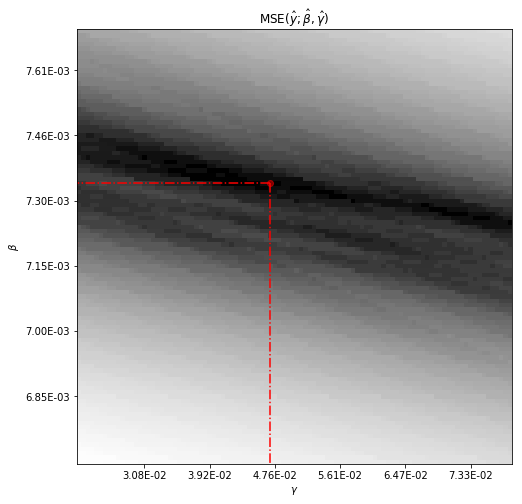

In [5]:
def example_lgs( ):
    
    # Number of samples
    nrof_samples = 500

    # Set physical parameters
    T_m = 1e-8; T_sampling = 1e-4; delta_0 = 5e-6; f_d = 73; phase_s = 3*np.pi/4; rho = 2;

    # Set noise levels
    SNR_out = 30; SNR_in = 30

    # Derive related quantities
    # Get S's period
    T_s = T_m / (1 + T_m * f_d)
    # Obtain standard parameters
    alpha, beta, gamma, psi = to_standard_parameters( T_sampling = T_sampling, delta_0 = delta_0, rho = rho,
                                                      f_d = f_d, T_s = T_s, phase_s = phase_s )

    # Get noise stds as a function of the inner and outer SNRs
    w_std = np.abs( psi ) * 10**( - SNR_out / 20 )
    v_std = 10**( - SNR_in / 20 )

    # Generate signal
    y = generate_signal( nrof_samples = nrof_samples, beta = beta, gamma = gamma, alpha = alpha, psi = psi,
                         w_std = w_std, v_std = v_std )

    # Estimate standard parameters by PCP
    (PCP_alpha, PCP_beta, PCP_gamma, PCP_time) = PCP( y, psi_function = ( 
                                                      lambda beta: psi_function( beta, T_sampling, T_m ) ), 
                                                      return_time = True )

    # Compute the implied physical parameters from the PCP-estimated standard parameters
    PCP_f_d, PCP_phase_s, PCP_rho = to_physical_parameters( alpha = PCP_alpha, beta = PCP_beta, gamma = PCP_gamma, 
                                                            T_m = T_m, T_sampling = T_sampling, delta_0 = delta_0 )

    # Estimate standard parameters by LGS around the estimate given by PCP (re-run from inside grid_search)
    (lgs_alpha, lgs_beta, 
     lgs_gamma, lgs_time) = grid_search( y, nrof_points = np.array( [100, 100] ), psi_function = ( 
                                         lambda beta: psi_function( beta, T_sampling, T_m ) ), 
                                         plots = True, return_time = True )
    
    # Compute the implied physical parameters from the LGS-estimated standard parameters
    (lgs_f_d, lgs_phase_s, lgs_rho) = to_physical_parameters( alpha = lgs_alpha, beta = lgs_beta, gamma = lgs_gamma, 
                                                              T_m = T_m, T_sampling = T_sampling, delta_0 = delta_0 )
    
    # Show the plots before any tables
    if interactive:
        mpl_to_pltly( plt.gcf( ) )
    else:
        plt.show( )

    # Print true and estimated values for standard parameters
    print("\n")
    print( tabulate( [ [ "True", str( alpha ), str( beta ), str( gamma ) ], 
                       [ "PCP", str( PCP_alpha ), str( PCP_beta ), str( PCP_gamma ) ],
                       [ "LGS", str( lgs_alpha ), str( lgs_beta ), str( lgs_gamma ) ],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error", str( np.abs( PCP_alpha - alpha ) ), 
                                      str( np.abs( PCP_beta  - beta  ) ),
                                      str( np.abs( PCP_gamma - gamma ) )],
                       [ "LGS error", str( np.abs( lgs_alpha - alpha ) ), 
                                      str( np.abs( lgs_beta  - beta  ) ),
                                      str( np.abs( lgs_gamma - gamma ) )],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error / LGS error", 
                        str( np.abs( PCP_alpha - alpha ) / np.abs( lgs_alpha - alpha ) ),
                        str( np.abs( PCP_beta  - beta  ) / np.abs( lgs_beta  - beta  ) ), 
                        str( np.abs( PCP_gamma - gamma ) / np.abs( lgs_gamma - gamma ) ) ] ], 
                    headers = [ 'alpha', 'beta', 'gamma' ] ) )
    print( "\n\tTab. 1: Performance on standard parameters" )

    # Print true and estimated values for physical clock synchronization and ranging parameters
    print("\n")
    print( tabulate( [ [ "True", str( rho ), str( f_d ), str( phase_s ) ], 
                       [ "PCP", str( PCP_rho ), str( PCP_f_d ), str( PCP_phase_s ) ],
                       [ "LGS", str( lgs_rho ), str( lgs_f_d ),  str( lgs_phase_s ) ],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error", str( np.abs( PCP_rho - rho ) ), 
                                      str( np.abs( PCP_f_d  - f_d  ) ),
                                      str( np.abs( PCP_phase_s - phase_s ) )],
                       [ "LGS error", str( np.abs( lgs_rho - rho ) ), 
                                      str( np.abs( lgs_f_d  - f_d  ) ),
                                      str( np.abs( lgs_phase_s - phase_s ) )],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error / LGS error", 
                        str( np.abs( PCP_rho - rho )         / np.abs( lgs_rho - rho ) ),
                        str( np.abs( PCP_f_d  - f_d  )       / np.abs( lgs_f_d  - f_d  ) ), 
                        str( np.abs( PCP_phase_s - phase_s ) / np.abs( lgs_phase_s - phase_s ) ) ] ],
                    headers = [ 'rho', 'f_d', 'phi_s' ] ) )
    print( "\n\tTab. 2: Performance on physical clock synchronization and ranging parameters" )

    # Print time taken by the different approaches
    print( "\n" )
    print( tabulate( [[ "PCP", "%f"%( PCP_time ) ], [ "LGS", "%f"%( lgs_time ) ],
                      [ "----", "----"], ["LGS time / PCP time", "%f"%( lgs_time / PCP_time ) ] ], 
                    headers = ["Time [s]"] ) )
    print( "\n\tTab. 3: Execution time comparison")

if run_examples:
    example_lgs( )

## Example of use of the GGS on standard and physical parameters
<a id="example_3"></a>
[Back to index](#index)

**<span style="color:red">Warning</span>**: GGS is excessively complex and memory demanding. This example alone requires roughly <u>**10 GB** of free RAM memory</u>.



                       alpha                   beta                    gamma
---------------------  ----------------------  ----------------------  --------------------
True                   5.023333326033339e-06   0.0073                  0.16666715333333326
PCP                    5.023360423007605e-06   0.0072                  0.15839999999999999
LGS                    5.023440122859762e-06   0.007381362725450901    0.15111999999999998
GGS                    5.023441269704555e-06   0.007383783783783784    0.15063063063063065
---------              ---------               ---------               ---------
PCP error              2.709697426580101e-11   0.00010000000000000026  0.008267153333333277
LGS error              1.0679682642282583e-10  8.136272545090136e-05   0.015547153333333286
GGS error              1.0794367121592815e-10  8.3783783783784e-05     0.016036522702702616
---------              ---------               ---------               ---------
PCP error / LGS error  0.25

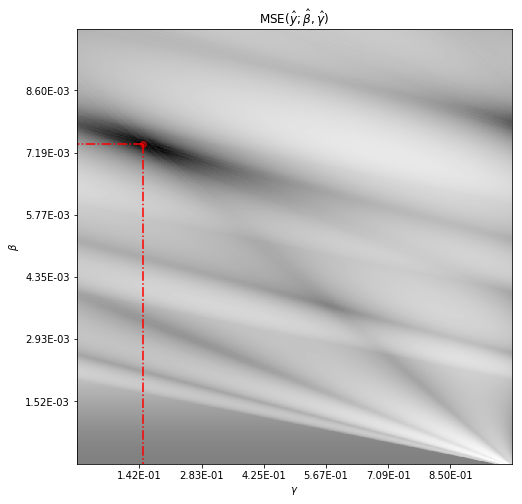

In [6]:
def example_ggs( ):
    
    # Number of samples
    nrof_samples = 500

    # Set physical parameters
    T_m = 1e-8; T_sampling = 1e-4; delta_0 = 5e-6; f_d = 73; phase_s = np.pi; rho = 2;

    # Set noise levels
    SNR_out = 30; SNR_in = 30

    # Derive related quantities
    # Get S's period
    T_s = T_m / (1 + T_m * f_d)
    # Obtain standard parameters
    alpha, beta, gamma, psi = to_standard_parameters( T_sampling = T_sampling, delta_0 = delta_0, rho = rho,
                                                      f_d = f_d, T_s = T_s, phase_s = phase_s )

    # Get noise stds as a function of the inner and outer SNRs
    w_std = np.abs( psi ) * 10**( - SNR_out / 20 )
    v_std = 10**( - SNR_in / 20 )

    # Generate signal
    y = generate_signal( nrof_samples = nrof_samples, beta = beta, gamma = gamma, alpha = alpha, psi = psi,
                         w_std = w_std, v_std = v_std )

    # Estimate standard parameters by PCP
    PCP_alpha, PCP_beta, PCP_gamma, PCP_time = PCP( y, 
               psi_function = ( lambda beta: psi_function( beta, T_sampling, T_m ) ), return_time = True )

    # Compute the implied physical clock synchronization and ranging from the PCP estimated standard parameters
    PCP_f_d, PCP_phase_s, PCP_rho = to_physical_parameters( alpha = PCP_alpha, beta = PCP_beta, gamma = PCP_gamma, 
                                                            T_m = T_m, T_sampling = T_sampling, delta_0 = delta_0 )

    # Estimate standard parameters by LGS around the estimate given by PCP (re-run from inside grid_search)
    lgs_alpha, lgs_beta, lgs_gamma, lgs_time = grid_search( y, 
               psi_function = ( lambda beta: psi_function( beta, T_sampling, T_m ) ), return_time = True )

    # Compute the implied physical clock synchronization and ranging from the LGS estimated standard parameters
    lgs_f_d, lgs_phase_s, lgs_rho = to_physical_parameters( alpha = lgs_alpha, beta = lgs_beta, gamma = lgs_gamma,
                                                            T_m = T_m, T_sampling = T_sampling, delta_0 = delta_0 )

    # Estimate standard parameters by GGS
    ggs_alpha, ggs_beta, ggs_gamma, ggs_time = grid_search( y, mode = 'global', 
               interval_gamma = np.array([0,0.99]), interval_beta = np.array( [.0001, .01] ), 
               nrof_points = np.array([1000, 1000]), 
               psi_function = ( lambda beta: psi_function( beta, T_sampling, T_m ) ), 
               plots = True, return_time = True )

    # Compute the implied physical clock synchronization and ranging from the GGS estimated standard parameters
    ggs_f_d, ggs_phase_s, ggs_rho = to_physical_parameters( alpha = ggs_alpha, beta = ggs_beta, gamma = ggs_gamma,
                                                            T_m = T_m, T_sampling = T_sampling, delta_0 = delta_0 )

    # If selected, export plots to LaTeX
    if export_to_latex:
        for fig_idx in plt.get_fignums( ):
            plt.figure( fig_idx )
            tikz_save( "GGS_example_%d.tex"%( fig_idx ) )

    # Show plots before any tables
    if interactive:
        mpl_to_pltly( plt.figure( 2 ) )
    else:
        plt.show( )

    # Print true and estimated values for standard parameters
    print("\n")
    print( tabulate( [ [ "True", str( alpha ), str( beta ), str( gamma ) ], 
                       [ "PCP", str( PCP_alpha ), str( PCP_beta ), str( PCP_gamma ) ],
                       [ "LGS", str( lgs_alpha ), str( lgs_beta ), str( lgs_gamma ) ],
                       [ "GGS", str( ggs_alpha ), str( ggs_beta ), str( ggs_gamma ) ],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error", str( np.abs( PCP_alpha - alpha ) ), 
                                      str( np.abs( PCP_beta  - beta  ) ),
                                      str( np.abs( PCP_gamma - gamma ) )],
                       [ "LGS error", str( np.abs( lgs_alpha - alpha ) ), 
                                      str( np.abs( lgs_beta  - beta  ) ),
                                      str( np.abs( lgs_gamma - gamma ) )],
                       [ "GGS error", str( np.abs( ggs_alpha - alpha ) ), 
                                      str( np.abs( ggs_beta  - beta  ) ),
                                      str( np.abs( ggs_gamma - gamma ) )],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error / LGS error", 
                        str( np.abs( PCP_alpha - alpha ) / np.abs( lgs_alpha - alpha ) ),
                        str( np.abs( PCP_beta  - beta  ) / np.abs( lgs_beta  - beta  ) ), 
                        str( np.abs( PCP_gamma - gamma ) / np.abs( lgs_gamma - gamma ) ) ],
                       [ "PCP error / GGS error", 
                        str( np.abs( PCP_alpha - alpha ) / np.abs( ggs_alpha - alpha ) ),
                        str( np.abs( PCP_beta  - beta  ) / np.abs( ggs_beta  - beta  ) ), 
                        str( np.abs( PCP_gamma - gamma ) / np.abs( ggs_gamma - gamma ) ) ] ], 
                    headers = [ 'alpha', 'beta', 'gamma' ] ) )
    print( "\n\tTab. 1: Performance on standard parameters" )

    # Print true and estimated values for physical clock synchronization and ranging parameters
    print("\n")
    print( tabulate( [ [ "True", str( rho ),    str( f_d ),     str( phase_s ) ], 
                       [ "PCP", str( PCP_rho ), str( PCP_f_d ), str( PCP_phase_s ) ],
                       [ "LGS", str( lgs_rho ), str( lgs_f_d ), str( lgs_phase_s ) ],
                       [ "GGS", str( ggs_rho ), str( ggs_f_d ), str( ggs_phase_s ) ],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error", str( np.abs( PCP_rho - rho ) ), 
                                      str( np.abs( PCP_f_d  - f_d  ) ),
                                      str( np.abs( PCP_phase_s - phase_s ) )],
                       [ "LGS error", str( np.abs( lgs_rho - rho ) ), 
                                      str( np.abs( lgs_f_d  - f_d  ) ),
                                      str( np.abs( lgs_phase_s - phase_s ) )],
                       [ "GGS error", str( np.abs( ggs_rho - rho ) ), 
                                      str( np.abs( ggs_f_d  - f_d  ) ),
                                      str( np.abs( ggs_phase_s - phase_s ) )],
                       [ "---------", "---------", "---------", "---------"],
                       [ "PCP error / LGS error", 
                        str( np.abs( PCP_rho - rho )       / np.abs( lgs_rho - rho ) ),
                        str( np.abs( PCP_f_d  - f_d  )     / np.abs( lgs_f_d  - f_d  ) ), 
                        str( np.abs( PCP_phase_s - phase_s ) / np.abs( lgs_phase_s - phase_s ) ) ],
                       [ "PCP error / GGS error", 
                        str( np.abs( PCP_rho - rho )       / np.abs( ggs_rho - rho ) ),
                        str( np.abs( PCP_f_d  - f_d )      / np.abs( ggs_f_d  - f_d  ) ), 
                        str( np.abs( PCP_phase_s - phase_s ) / np.abs( ggs_phase_s - phase_s ) ) ] ],
                    headers = [ 'rho', 'f_d', 'phi_s' ] ) )
    print( "\n\tTab. 2: Performance on physical clock synchronization and ranging parameters" )

    # Print time taken by the different approaches
    print( "\n" )
    print( tabulate( [[ "PCP", "%f"%( PCP_time ) ], [ "LGS", "%f"%( lgs_time ) ], [ "GGS", "%f"%( ggs_time ) ],
                      [ "----", "----"], ["LGS time / PCP time", "%f"%( lgs_time / PCP_time ) ], 
                      [ "GGS time / PCP time", "%f"%( ggs_time / PCP_time ) ] ], 
                    headers = ["Time [s]"] ) )
    print( "\n\tTab. 3: Execution time comparison")

if run_examples:
    example_ggs( )